In [1]:
%matplotlib widget
import numpy as np
import quaternion as Q
import matplotlib.pyplot as plt

# Orientation Trajectory Generation

Simulate an object undergoing random rotations, and produce a measurement vector consisting of acceleration, and angular velocity data. 

ToDo: Also include a random walk of the particle in translational DoF so that these accelerations can be applied to the accelerometer meaurement.

[ 1. -0.  0.  0.  0.  0.  0.]


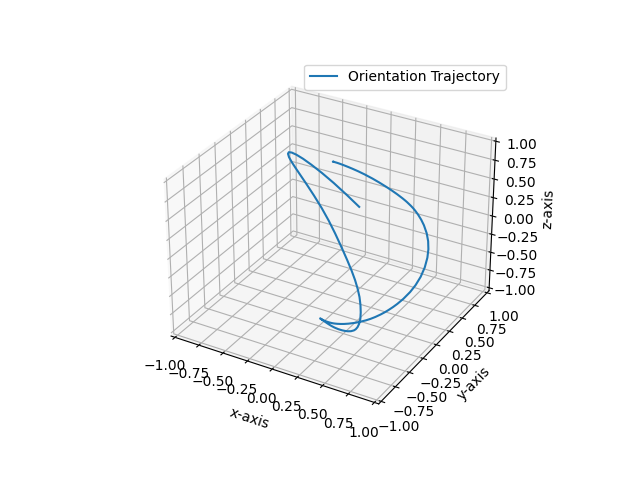

In [33]:
def q_inv(q):
    # quaternion inverse
    conj = np.array(Q.as_float_array(q)) * np.array([1, -1, -1, -1])
    mag2 = np.dot(conj, conj)
    return Q.from_float_array(conj / mag2)

def X_0(q_0=Q.from_euler_angles(0, 0, 0), w_0=np.zeros(3)):
    # initialize state vector
    return q_0, w_0

def X_t_1(X_t, dt, stddev=np.ones(3), bias=np.zeros(3)):
    # Compute the next step of X given some normally distributed
    # random angular acceleration
    q_t, w_t = X_t
    
    # Generate a random angular acceleration in the inertial frame
    w_dot = (stddev ** 2) * np.random.randn(3) + bias
    
    w_t_1 = w_t + w_dot * dt # ang. vel. update from ang. acc.
    q_t_1 = q_t * Q.from_euler_angles(w_t_1 * dt) # orientation update in global frame
    
    return q_t_1, w_t_1

def X_t_1_const(X_t, dt, stddev=np.ones(3), bias=np.zeros(3)):
    # Compute the next step of X given some normally distributed
    # random angular acceleration
    q_t, w_t = X_t
    
    # Generate a random angular acceleration in the inertial frame
    w_dot = np.array([0, 1, 0])
    
    w_t_1 = w_t + w_dot * dt # ang. vel. update from ang. acc.
    q_t_1 = q_t * Q.from_euler_angles(w_t_1 * dt) # orientation update in global frame
    
    return q_t_1, w_t_1

def X_to_array(x):
    return np.concatenate((Q.as_float_array(x[0]), x[1]), dtype=np.float32)

def Z_t(X_t):
    # produce measurements from true state
    acc = Q.rotate_vectors(q_inv(X_t[0]), np.array([0, 0, -1]))
    gyro = X_t[1]
    return np.concatenate((gyro, acc))

steps = 100
positions = np.zeros((steps, 3), dtype=np.float32) # sequence of z-basis unit vectors rotated by orientation for plotting
w_samples = np.zeros((steps, 3), dtype=np.float32) # sequence of angular rate measurements
measurements = np.zeros((steps, Z_t(X_0()).shape[0]), dtype=np.float32) # sequence of static accelerometer readings 
ground_truth = np.zeros((steps, X_to_array(X_0()).shape[0]), dtype=np.float32) # labels for training

samples = np.zeros((steps, 4 + Z_t(X_0()).shape[0]), dtype=np.float32) # consists of the t-1 orientation, and measurements from t
labels = np.zeros((steps, 4), dtype=np.float32) # orientation estimate for t

X_t = X_0()

print(X_to_array(X_t))

for i in range(steps):
    positions[i] = Q.rotate_vectors(X_t[0], np.array([0, 0, 1]))
    measurements[i] = Z_t(X_t)
    ground_truth[i] = X_to_array(X_t)
    
    samples[i] = np.concatenate((ground_truth[i,:4], measurements[i]), dtype=np.dtype(float))
    
    # propagate the state
    X_t = X_t_1(X_t, 0.01, stddev=np.ones(3) * 10)
    
    labels[i] = ground_truth[i,:4]
    

ax = plt.figure().add_subplot(projection='3d')

ax.plot(positions[:,0], positions[:,1], positions[:,2], label='Orientation Trajectory')
ax.legend()
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

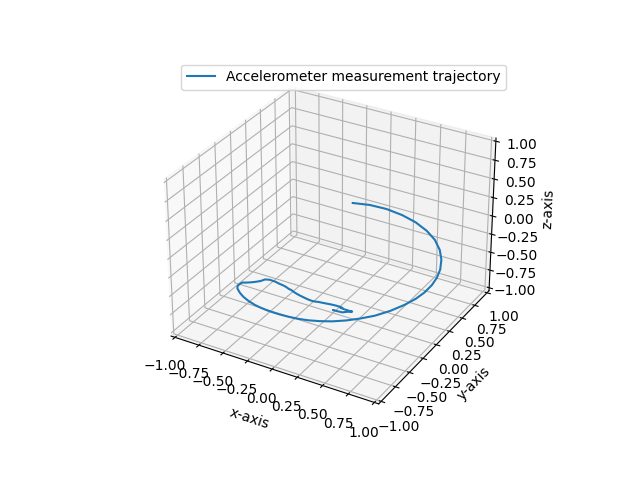

In [29]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(measurements[:,3], measurements[:,4], measurements[:,5], label='Accelerometer measurement trajectory')
ax.legend()
plt.xlim([-1, 1])
plt.ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

Using cpu device


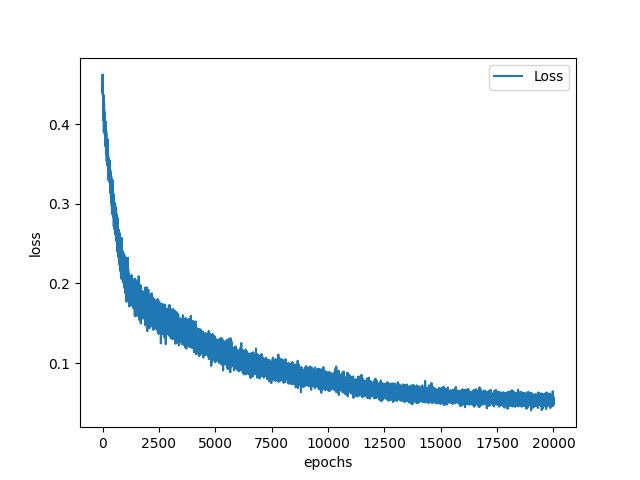

In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 16, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(16, 16, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(16, 4, dtype=torch.float32)
        )

    def forward(self, x):
#         print(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)


def train_loop(model, loss_fn, optimizer):
    epochs = 20000
    sample_indices = list(range(samples.shape[0]))
    losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        batch_inds = np.random.choice(sample_indices, size=len(sample_indices))
        X = torch.from_numpy(samples[batch_inds])
        Y = torch.from_numpy(labels[batch_inds])
        
        h = model(X)
        loss = loss_fn(h, Y)

        losses[epoch] = loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#         if epoch % 100 == 0:
#             loss, current = loss.item(), epoch * len(X)
#             print(f"loss: {loss:>7f}  [{epoch:>5d}/{epochs:>5d}]")

    ax = plt.figure().add_subplot()
    ax.plot(losses, label='Loss')
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.show()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()

train_loop(model, loss_fn, optimizer)

[ 1. -0.  0.  0.  0.  0.  0.]


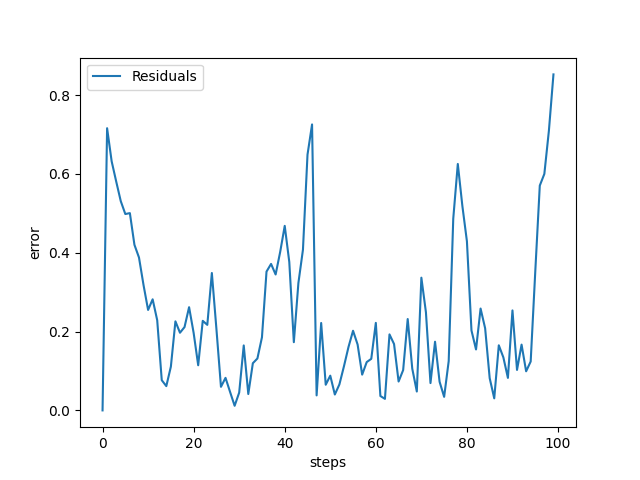

In [47]:
X_t = X_0()
X_e_t = X_0()
est_positions = np.zeros((steps, 3), dtype=np.float32) # sequence of z-basis unit vectors rotated by orientation for plotting

print(X_to_array(X_t))

for i in range(steps):
    est_positions[i] = Q.rotate_vectors(X_e_t[0], np.array([0, 0, 1]))
    
    np_features = np.concatenate((Q.as_float_array(X_e_t[0]), measurements[i]), dtype=np.float32)
    features = torch.from_numpy(np_features.reshape((1, np_features.shape[0])))
    h = model(features)
    X_e_t = (Q.from_float_array(h[0].detach().numpy()), X_e_t[1])

residuals = []
for r in (est_positions - positions):
    residuals.append(np.linalg.norm(r))


ax = plt.figure().add_subplot()
ax.plot(residuals, label='Residuals')
ax.legend()
ax.set_xlabel('steps')
ax.set_ylabel('error')
plt.show()

    
# ax0 = plt.figure().add_subplot(projection='3d')
# ax1 = plt.figure().add_subplot(projection='3d')

# ax0.plot(est_positions[:,0], est_positions[:,1], est_positions[:,2], label='Estimated Orientation Trajectory')
# ax0.legend()
# plt.xlim([-1, 1])
# plt.ylim([-1, 1])
# ax0.set_zlim([-1, 1])
# ax0.set_xlabel('x-axis')
# ax0.set_ylabel('y-axis')
# ax0.set_zlabel('z-axis')

# ax1.plot(positions[:,0], positions[:,1], positions[:,2], label='Estimated Orientation Trajectory')
# ax1.legend()
# plt.xlim([-1, 1])
# plt.ylim([-1, 1])
# ax1.set_zlim([-1, 1])
# ax1.set_xlabel('x-axis')
# ax1.set_ylabel('y-axis')
# ax1.set_zlabel('z-axis')
# plt.show()

In [12]:
print(r)

[0.20794717 0.30633718 0.41980838 0.12507948 0.09237776 0.36080258
 0.33479161 0.1961395 ]


In [13]:
print(r[:4])

[0.20794717 0.30633718 0.41980838 0.12507948]
